In [1]:
#!pip install roboflow
#!pip install ultralytics==8.0.196
#!pip install tensorflow-addons

# Helper Functions

In [5]:
# Define helper functions specific to your dataset
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image

def load_label(label_path):
    label_file = tf.io.read_file(label_path)
    label_data = tf.strings.split(tf.strings.strip(label_file), ' ')
    class_id = tf.strings.to_number(label_data[0], out_type=tf.int32)
    return class_id

def create_dataset(folder):
    image_files = tf.data.Dataset.list_files(folder + '/images/*.jpg', shuffle=False)
    label_files = tf.data.Dataset.list_files(folder + '/labels/*.txt', shuffle=False)
    images_dataset = image_files.map(load_image)
    labels_dataset = label_files.map(load_label)
    dataset = tf.data.Dataset.zip((images_dataset, labels_dataset))
    return dataset

# Pull Down Data

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from roboflow import Roboflow

In [3]:
rf = Roboflow(api_key="VAAmaV7sJTB0v6rGIJfB")
project = rf.workspace("dluva").project("ship-vessel-identification")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Ship-Vessel-Identification-3 in yolov8:: 100%|██████████| 1420/1420 [00:00<00:00, 6962.46it/s]


In [18]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Count Classes

In [6]:
from tabulate import tabulate
import os

base_dir = "/content/Ship-Vessel-Identification-3"
train_folder = os.path.join(base_dir, "train")
valid_folder = os.path.join(base_dir, "valid")
test_folder = os.path.join(base_dir, "test")

# Initialize a dictionary to store the class counts
class_counts = {
    "Class": list(range(8)),
    "Train": [0] * 8,
    "Valid": [0] * 8,
    "Test": [0] * 8,
    "Total": [0] * 8
}

# Function to update class counts
def update_class_counts(folder, folder_name):
    images_dir = os.path.join(folder, "images")
    labels_dir = os.path.join(folder, "labels")

    if not os.path.exists(images_dir) or not os.path.exists(labels_dir):
        return

    for image_file in os.listdir(images_dir):
        label_file = image_file.replace('.jpg', '.txt')
        label_path = os.path.join(labels_dir, label_file)

        if not os.path.isfile(label_path):
            continue

        with open(label_path, 'r') as file:
            label_data = file.read().strip().split()
            class_id = int(label_data[0])
            class_counts[folder_name][class_id] += 1
            class_counts["Total"][class_id] += 1

# Update class counts for each folder
update_class_counts(train_folder, "Train")
update_class_counts(valid_folder, "Valid")
update_class_counts(test_folder, "Test")

# Calculate the sum of the "Total" column
total_sum = sum(class_counts["Total"])

# Add a row for the sum of the "Total" column
class_counts["Class"].append("Total")
class_counts["Train"].append("-")
class_counts["Valid"].append("-")
class_counts["Test"].append("-")
class_counts["Total"].append(total_sum)

# Print the class counts in a tabular format
print(tabulate(class_counts, headers="keys", tablefmt="grid"))

+---------+---------+---------+--------+---------+
| Class   | Train   | Valid   | Test   |   Total |
+=========+=========+=========+========+=========+
| 0       | 68      | 23      | 8      |      99 |
+---------+---------+---------+--------+---------+
| 1       | 75      | 20      | 6      |     101 |
+---------+---------+---------+--------+---------+
| 2       | 72      | 21      | 9      |     102 |
+---------+---------+---------+--------+---------+
| 3       | 64      | 20      | 10     |      94 |
+---------+---------+---------+--------+---------+
| 4       | 65      | 25      | 17     |     107 |
+---------+---------+---------+--------+---------+
| 5       | 66      | 14      | 11     |      91 |
+---------+---------+---------+--------+---------+
| 6       | 6       | 2       | 3      |      11 |
+---------+---------+---------+--------+---------+
| 7       | 75      | 15      | 9      |      99 |
+---------+---------+---------+--------+---------+
| Total   | -       | -       |

# 1. Baseline Model

*This is the model I used

- Loading the pre-trained VGG16 model
- Freezing the pre-trained layers
- Adding new layers on top
- Compiling the model
- Training the model with early stopping
- Fine-tuning the model (optional)

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
import io
import sys
import os

def create_model(input_shape, num_classes):
    # Load the pre-trained VGG16 model without the top classification layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    # Freeze the weights of the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False
    # Create a new model on top of the pre-trained model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create the model
input_shape = (224, 224, 3)  # Adjust based on your image size
num_classes = 8
model = create_model(input_shape, num_classes)

base_dir = "/content/Ship-Vessel-Identification-3"
train_folder = os.path.join(base_dir, "train")
val_folder = os.path.join(base_dir, "valid")
test_folder = os.path.join(base_dir, "test")

# Load and preprocess your ship vessel dataset
train_dataset = create_dataset(train_folder)
val_dataset = create_dataset(val_folder)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights from the best epoch
)

# Redirect stdout to capture the model summary
old_stdout = sys.stdout
sys.stdout = buffer = io.StringIO()

# Print the model summary
model.summary()

# Restore stdout
sys.stdout = old_stdout

# Get the model summary as a string
model_summary = buffer.getvalue()

# Print the model summary
print("Model Architecture:")
print(model_summary)

# Train the model with early stopping
history = model.fit(
    train_dataset.batch(32),
    epochs=10,
    validation_data=val_dataset.batch(32),
    callbacks=[early_stopping]  # Pass the early stopping callback to the fit function
)

def augment_batch(images, labels):
  # Apply random transformations to each image in the batch
  augmented_images = tf.map_fn(lambda x: augment_image(x), images)
  return augmented_images, labels

def augment_image(image):
  # Apply random transformations to the image
  image = tf.image.random_flip_left_right(image)  # Random horizontal flip
  image = tf.image.random_brightness(image, 0.2)
  return image

# Create the augmented and batched dataset
train_dataset_batched = train_dataset.batch(32)
train_dataset_augmented_batched = train_dataset_batched.map(augment_batch)

# Fine-tune the model (optional)
for layer in model.layers[:15]:  # Unfreeze the last 5 layers of VGG16
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Use a lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Create early stopping callback for fine-tuning
fine_tune_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

fine_tune_history = model.fit(
    train_dataset_augmented_batched,
    epochs=30,
    validation_data=val_dataset.batch(64),
    callbacks=[fine_tune_early_stopping]
)

Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 27564360 (105.15 MB)
Trainable params: 12849672 (49.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_____________________________________________________

### Accuracy Graphic

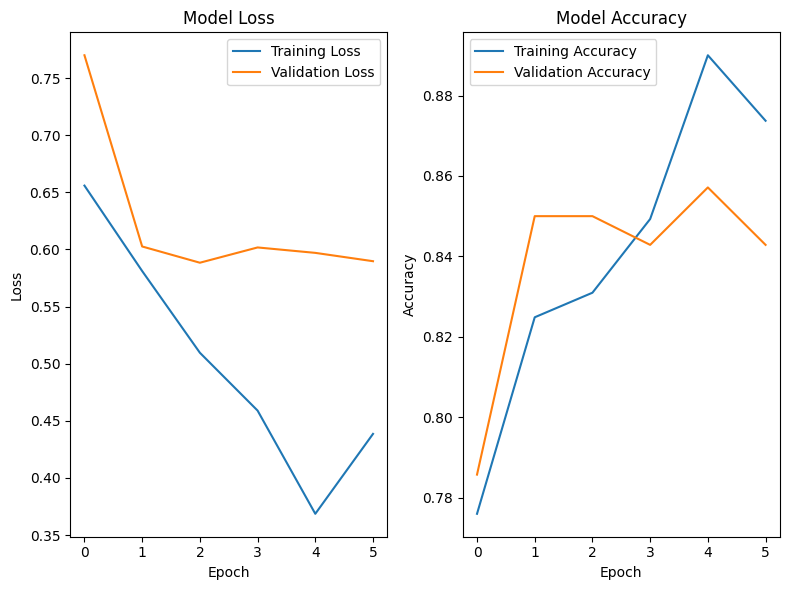

In [8]:
import matplotlib.pyplot as plt

# Plot the training and validation metrics
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Confusion Matrix

3/3 [==============================] - 4s 2s/step


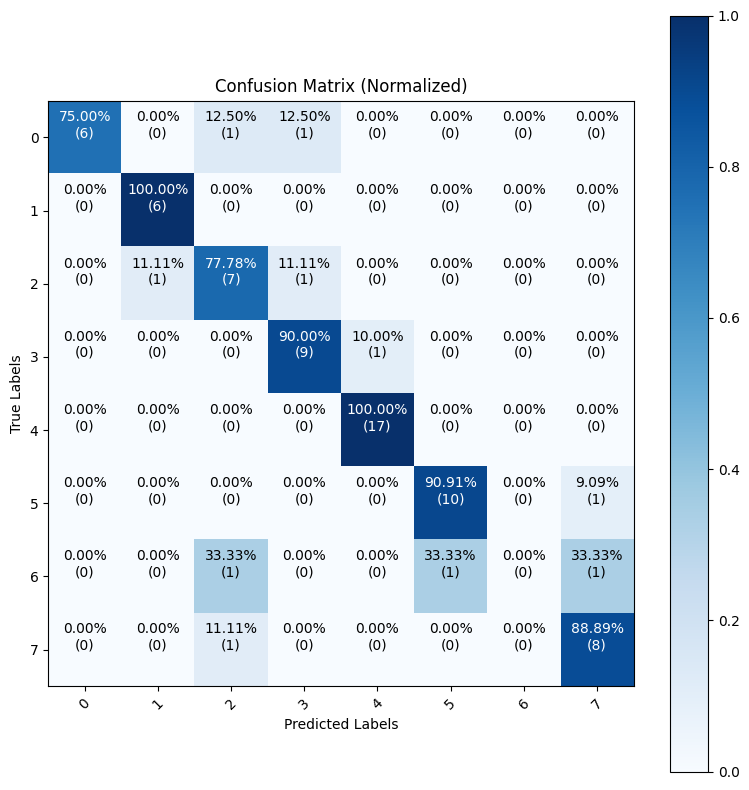

In [9]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow_datasets import load

# Make predictions on the test set
test_dataset = create_dataset("/content/Ship-Vessel-Identification-3/test")  # Adjust the path accordingly
test_images = []
test_labels = []
for images, labels in test_dataset:
    test_images.extend(images.numpy())
    test_labels.append(labels.numpy())
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Reshape the test images to include the channel dimension
test_images = test_images.reshape((-1, 224, 224, 3))
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Create the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Normalized)')
plt.colorbar()
tick_marks = np.arange(len(np.unique(test_labels)))
plt.xticks(tick_marks, np.unique(test_labels), rotation=45)
plt.yticks(tick_marks, np.unique(test_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add values on top of each cell
thresh = cm_norm.max() / 2.
for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
    plt.text(j, i, f"{cm_norm[i, j]*100:.2f}%\n({cm[i, j]})", horizontalalignment="center", color="white" if cm_norm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.86      1.00      0.92         6
           2       0.70      0.78      0.74         9
           3       0.82      0.90      0.86        10
           4       0.94      1.00      0.97        17
           5       0.91      0.91      0.91        11
           6       0.00      0.00      0.00         3
           7       0.80      0.89      0.84         9

    accuracy                           0.86        73
   macro avg       0.75      0.78      0.76        73
weighted avg       0.83      0.86      0.85        73



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


The model performs well on labels 1, 2, 3, 4, 5, and 7, with high precision, recall, and F1-scores, indicating good classification performance for these labels.

Best performance on 1 and 4.
Worst perforamnce on Model 0.

# Stable Diffusion Text to Images

In [12]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from roboflow import Roboflow

In [13]:
rf = Roboflow(api_key="VAAmaV7sJTB0v6rGIJfB")
project = rf.workspace("dluva").project("ship-vessel-identification-2_sd")
version = project.version(1)
dataset = version.download("yolov8-obb")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Ship-Vessel-Identification-2_SD-1 in yolov8-obb:: 100%|██████████| 1606/1606 [00:00<00:00, 7049.09it/s]


In [14]:
from tabulate import tabulate
import os

base_dir = "/content/Ship-Vessel-Identification-2_SD-1"
train_folder = os.path.join(base_dir, "train")
val_folder = os.path.join(base_dir, "valid")
test_folder = os.path.join(base_dir, "test")

# Load and preprocess your ship vessel dataset
train_dataset = create_dataset(train_folder)
val_dataset = create_dataset(val_folder)

# Initialize a dictionary to store the class counts
class_counts = {
    "Class": list(range(8)),
    "Train": [0] * 8,
    "Valid": [0] * 8,
    "Test": [0] * 8,
    "Total": [0] * 8
}

# Function to update class counts
def update_class_counts(folder, folder_name):
    images_dir = os.path.join(folder, "images")
    labels_dir = os.path.join(folder, "labels")

    if not os.path.exists(images_dir) or not os.path.exists(labels_dir):
        return

    for image_file in os.listdir(images_dir):
        label_file = image_file.replace('.jpg', '.txt')
        label_path = os.path.join(labels_dir, label_file)

        if not os.path.isfile(label_path):
            continue

        with open(label_path, 'r') as file:
            label_data = file.read().strip().split()
            class_id = int(label_data[0])
            class_counts[folder_name][class_id] += 1
            class_counts["Total"][class_id] += 1

# Update class counts for each folder
update_class_counts(train_folder, "Train")
update_class_counts(valid_folder, "Valid")
update_class_counts(test_folder, "Test")

# Calculate the sum of the "Total" column
total_sum = sum(class_counts["Total"])

# Add a row for the sum of the "Total" column
class_counts["Class"].append("Total")
class_counts["Train"].append("-")
class_counts["Valid"].append("-")
class_counts["Test"].append("-")
class_counts["Total"].append(total_sum)

# Print the class counts in a tabular format
print(tabulate(class_counts, headers="keys", tablefmt="grid"))

+---------+---------+---------+--------+---------+
| Class   | Train   | Valid   | Test   |   Total |
+=========+=========+=========+========+=========+
| 0       | 68      | 23      | 8      |      99 |
+---------+---------+---------+--------+---------+
| 1       | 75      | 20      | 6      |     101 |
+---------+---------+---------+--------+---------+
| 2       | 72      | 21      | 9      |     102 |
+---------+---------+---------+--------+---------+
| 3       | 64      | 20      | 10     |      94 |
+---------+---------+---------+--------+---------+
| 4       | 65      | 25      | 17     |     107 |
+---------+---------+---------+--------+---------+
| 5       | 66      | 14      | 11     |      91 |
+---------+---------+---------+--------+---------+
| 6       | 71      | 2       | 3      |      76 |
+---------+---------+---------+--------+---------+
| 7       | 75      | 15      | 9      |      99 |
+---------+---------+---------+--------+---------+
| Total   | -       | -       |

Model: SD Text to Image

In [15]:
def create_model(input_shape, num_classes):
    # Load the pre-trained VGG16 model without the top classification layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    # Freeze the weights of the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False
    # Create a new model on top of the pre-trained model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create the model
input_shape = (224, 224, 3)  # Adjust based on your image size
num_classes = 8
model = create_model(input_shape, num_classes)



# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights from the best epoch
)

# Train the model with early stopping
history = model.fit(
    train_dataset.batch(32),
    epochs=10,
    validation_data=val_dataset.batch(32),
    callbacks=[early_stopping]  # Pass the early stopping callback to the fit function
)

def augment_batch(images, labels):
  # Apply random transformations to each image in the batch
  augmented_images = tf.map_fn(lambda x: augment_image(x), images)
  return augmented_images, labels

def augment_image(image):
  # Apply random transformations to the image
  image = tf.image.random_flip_left_right(image)  # Random horizontal flip
  image = tf.image.random_brightness(image, 0.2)
  return image

# Create the augmented and batched dataset
train_dataset_batched = train_dataset.batch(32)
train_dataset_augmented_batched = train_dataset_batched.map(augment_batch)

# Fine-tune the model (optional)
for layer in model.layers[:15]:  # Unfreeze the last 5 layers of VGG16
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Use a lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Create early stopping callback for fine-tuning
fine_tune_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

fine_tune_history = model.fit(
    train_dataset_augmented_batched,
    epochs=30,
    validation_data=val_dataset.batch(64),
    callbacks=[fine_tune_early_stopping]
)

Epoch 1/10
18/18 [==============================] - 7s 372ms/step - loss: 31.6150 - accuracy: 0.0863 - val_loss: 7.8896 - val_accuracy: 0.1845
Epoch 2/10
18/18 [==============================] - 3s 187ms/step - loss: 7.5913 - accuracy: 0.1133 - val_loss: 1.0986 - val_accuracy: 0.6131
Epoch 3/10
18/18 [==============================] - 3s 190ms/step - loss: 1.9285 - accuracy: 0.3651 - val_loss: 1.0443 - val_accuracy: 0.6488
Epoch 4/10
18/18 [==============================] - 3s 187ms/step - loss: 1.2109 - accuracy: 0.5683 - val_loss: 1.0723 - val_accuracy: 0.6071
Epoch 5/10
18/18 [==============================] - 3s 190ms/step - loss: 1.0411 - accuracy: 0.6277 - val_loss: 0.7832 - val_accuracy: 0.7738
Epoch 6/10
18/18 [==============================] - 3s 190ms/step - loss: 0.8008 - accuracy: 0.7302 - val_loss: 0.6896 - val_accuracy: 0.7857
Epoch 7/10
18/18 [==============================] - 3s 187ms/step - loss: 0.6433 - accuracy: 0.7662 - val_loss: 0.6278 - val_accuracy: 0.8333
Epoch

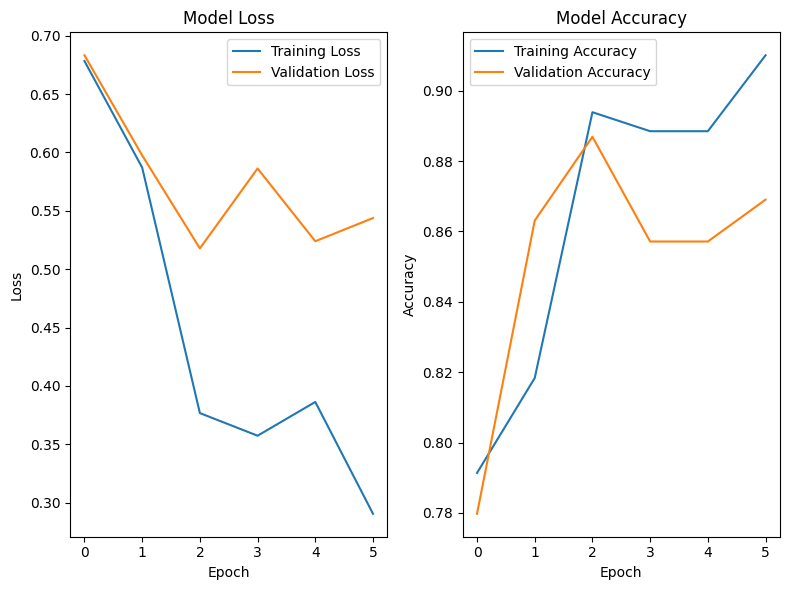

In [16]:
# Plot the training and validation metrics
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

3/3 [==============================] - 0s 123ms/step


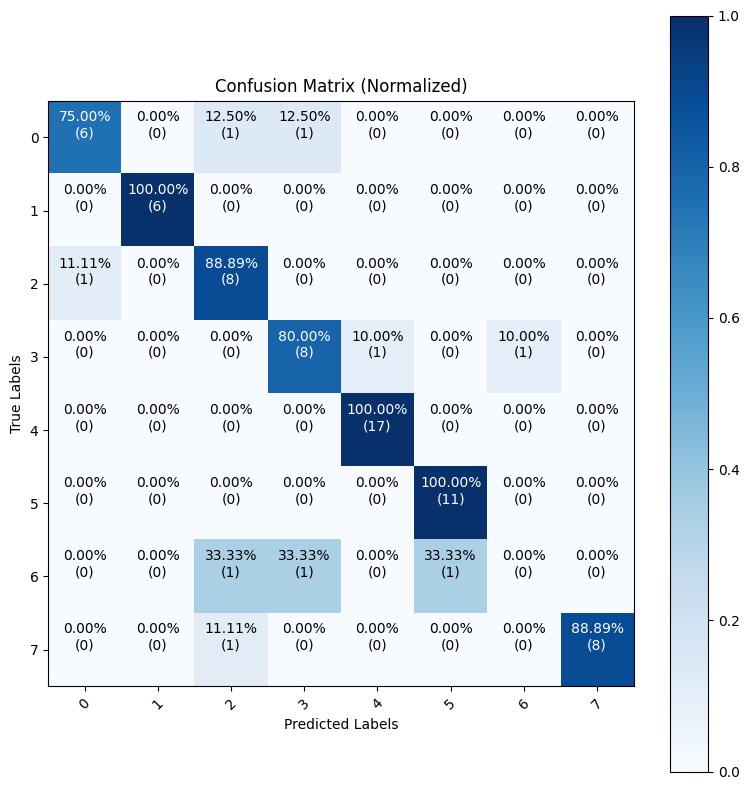

In [17]:
# Make predictions on the test set
test_dataset = create_dataset("/content/Ship-Vessel-Identification-2_SD-1/test")
test_images = []
test_labels = []
for images, labels in test_dataset:
    test_images.extend(images.numpy())
    test_labels.append(labels.numpy())
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Reshape the test images to include the channel dimension
test_images = test_images.reshape((-1, 224, 224, 3))
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Create the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Normalized)')
plt.colorbar()
tick_marks = np.arange(len(np.unique(test_labels)))
plt.xticks(tick_marks, np.unique(test_labels), rotation=45)
plt.yticks(tick_marks, np.unique(test_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add values on top of each cell
thresh = cm_norm.max() / 2.
for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
    plt.text(j, i, f"{cm_norm[i, j]*100:.2f}%\n({cm[i, j]})", horizontalalignment="center", color="white" if cm_norm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       1.00      1.00      1.00         6
           2       0.73      0.89      0.80         9
           3       0.80      0.80      0.80        10
           4       0.94      1.00      0.97        17
           5       0.92      1.00      0.96        11
           6       0.00      0.00      0.00         3
           7       1.00      0.89      0.94         9

    accuracy                           0.88        73
   macro avg       0.78      0.79      0.78        73
weighted avg       0.86      0.88      0.86        73



# Stable Diffusion: Image Variants 1

In [20]:
from roboflow import Roboflow
rf = Roboflow(api_key="VAAmaV7sJTB0v6rGIJfB")
project = rf.workspace("dluva").project("ship-vessel-identification-2_sd_imageprompt")
version = project.version(1)
dataset = version.download("yolov8-obb")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Ship-Vessel-Identification-2_SD_ImagePrompt-1 in yolov8-obb:: 100%|██████████| 1458/1458 [00:00<00:00, 6926.73it/s]


In [21]:
from tabulate import tabulate
import os

base_dir = "/content/Ship-Vessel-Identification-2_SD_ImagePrompt-1"
train_folder = os.path.join(base_dir, "train")
val_folder = os.path.join(base_dir, "valid")
test_folder = os.path.join(base_dir, "test")

# Load and preprocess your ship vessel dataset
train_dataset = create_dataset(train_folder)
val_dataset = create_dataset(val_folder)

# Initialize a dictionary to store the class counts
class_counts = {
    "Class": list(range(8)),
    "Train": [0] * 8,
    "Valid": [0] * 8,
    "Test": [0] * 8,
    "Total": [0] * 8
}

# Function to update class counts
def update_class_counts(folder, folder_name):
    images_dir = os.path.join(folder, "images")
    labels_dir = os.path.join(folder, "labels")

    if not os.path.exists(images_dir) or not os.path.exists(labels_dir):
        return

    for image_file in os.listdir(images_dir):
        label_file = image_file.replace('.jpg', '.txt')
        label_path = os.path.join(labels_dir, label_file)

        if not os.path.isfile(label_path):
            continue

        with open(label_path, 'r') as file:
            label_data = file.read().strip().split()
            class_id = int(label_data[0])
            class_counts[folder_name][class_id] += 1
            class_counts["Total"][class_id] += 1

# Update class counts for each folder
update_class_counts(train_folder, "Train")
update_class_counts(val_folder, "Valid")
update_class_counts(test_folder, "Test")

# Calculate the sum of the "Total" column
total_sum = sum(class_counts["Total"])

# Add a row for the sum of the "Total" column
class_counts["Class"].append("Total")
class_counts["Train"].append("-")
class_counts["Valid"].append("-")
class_counts["Test"].append("-")
class_counts["Total"].append(total_sum)

# Print the class counts in a tabular format
print(tabulate(class_counts, headers="keys", tablefmt="grid"))

+---------+---------+---------+--------+---------+
| Class   | Train   | Valid   | Test   |   Total |
+=========+=========+=========+========+=========+
| 0       | 68      | 23      | 8      |      99 |
+---------+---------+---------+--------+---------+
| 1       | 75      | 20      | 6      |     101 |
+---------+---------+---------+--------+---------+
| 2       | 72      | 21      | 9      |     102 |
+---------+---------+---------+--------+---------+
| 3       | 64      | 20      | 10     |      94 |
+---------+---------+---------+--------+---------+
| 4       | 65      | 25      | 17     |     107 |
+---------+---------+---------+--------+---------+
| 5       | 66      | 14      | 11     |      91 |
+---------+---------+---------+--------+---------+
| 6       | 19      | 8       | 3      |      30 |
+---------+---------+---------+--------+---------+
| 7       | 75      | 15      | 9      |      99 |
+---------+---------+---------+--------+---------+
| Total   | -       | -       |

In [22]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
import io
import sys

def create_model(input_shape, num_classes):
    # Load the pre-trained VGG16 model without the top classification layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    # Freeze the weights of the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False
    # Create a new model on top of the pre-trained model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create the model
input_shape = (224, 224, 3)  # Adjust based on your image size
num_classes = 8
model = create_model(input_shape, num_classes)


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights from the best epoch
)

# Train the model with early stopping
history = model.fit(
    train_dataset.batch(32),
    epochs=10,
    validation_data=val_dataset.batch(32),
    callbacks=[early_stopping]  # Pass the early stopping callback to the fit function
)

def augment_batch(images, labels):
  # Apply random transformations to each image in the batch
  augmented_images = tf.map_fn(lambda x: augment_image(x), images)
  return augmented_images, labels

def augment_image(image):
  # Apply random transformations to the image
  image = tf.image.random_flip_left_right(image)  # Random horizontal flip
  image = tf.image.random_brightness(image, 0.2)
  return image

# Create the augmented and batched dataset
train_dataset_batched = train_dataset.batch(32)
train_dataset_augmented_batched = train_dataset_batched.map(augment_batch)

# Fine-tune the model (optional)
for layer in model.layers[:15]:  # Unfreeze the last 5 layers of VGG16
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Use a lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Create early stopping callback for fine-tuning
fine_tune_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

fine_tune_history = model.fit(
    train_dataset_augmented_batched,
    epochs=30,
    validation_data=val_dataset.batch(64),
    callbacks=[fine_tune_early_stopping]
)

Epoch 1/10
16/16 [==============================] - 18s 1s/step - loss: 21.2131 - accuracy: 0.0952 - val_loss: 7.0040 - val_accuracy: 0.0959
Epoch 2/10
16/16 [==============================] - 3s 197ms/step - loss: 6.9862 - accuracy: 0.1091 - val_loss: 1.9363 - val_accuracy: 0.2808
Epoch 3/10
16/16 [==============================] - 3s 195ms/step - loss: 2.1443 - accuracy: 0.3254 - val_loss: 1.5701 - val_accuracy: 0.4658
Epoch 4/10
16/16 [==============================] - 3s 192ms/step - loss: 1.4655 - accuracy: 0.4504 - val_loss: 1.3046 - val_accuracy: 0.6301
Epoch 5/10
16/16 [==============================] - 3s 190ms/step - loss: 1.2326 - accuracy: 0.5278 - val_loss: 1.1523 - val_accuracy: 0.6233
Epoch 6/10
16/16 [==============================] - 3s 187ms/step - loss: 1.1887 - accuracy: 0.5298 - val_loss: 1.1022 - val_accuracy: 0.7055
Epoch 7/10
16/16 [==============================] - 3s 186ms/step - loss: 1.1019 - accuracy: 0.6230 - val_loss: 0.9558 - val_accuracy: 0.7534
Epoch 8

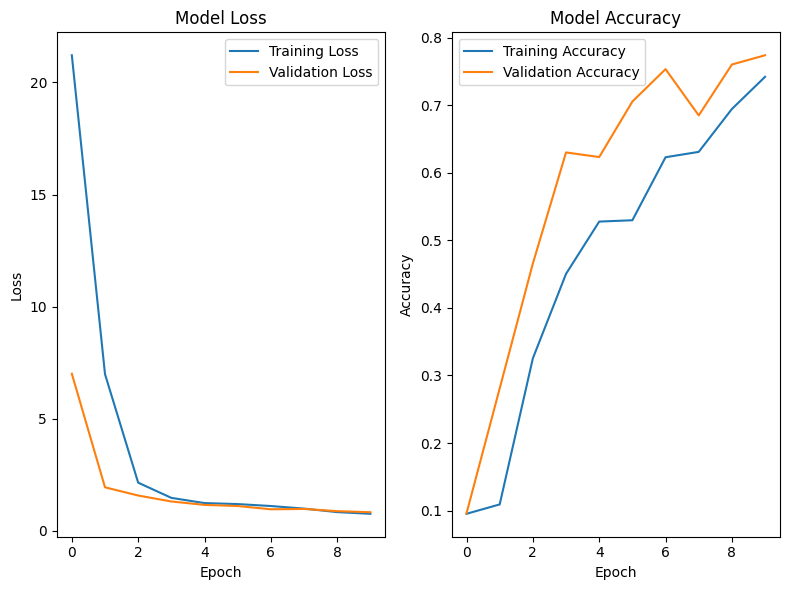

In [23]:
# Plot the training and validation metrics
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

3/3 [==============================] - 0s 123ms/step


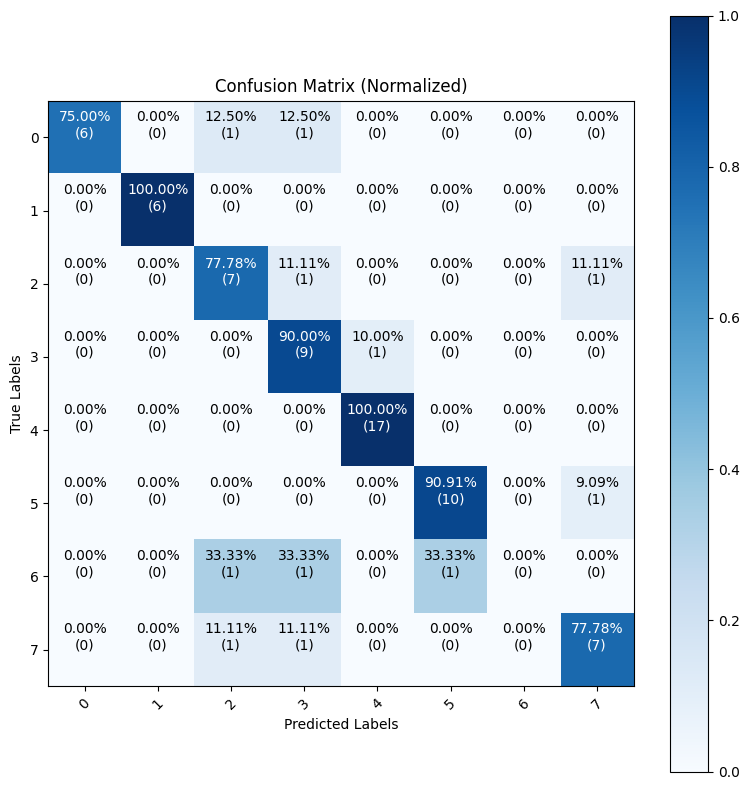

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

# Make predictions on the test set
test_dataset = create_dataset("/content/Ship-Vessel-Identification-2_SD_ImagePrompt-1/test")  # Adjust the path accordingly
test_images = []
test_labels = []

for images, labels in test_dataset:
    test_images.extend(images.numpy())
    test_labels.append(labels.numpy())
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Reshape the test images to include the channel dimension
test_images = test_images.reshape((-1, 224, 224, 3))
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Create the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Normalized)')
plt.colorbar()
tick_marks = np.arange(len(np.unique(test_labels)))
plt.xticks(tick_marks, np.unique(test_labels), rotation=45)
plt.yticks(tick_marks, np.unique(test_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add values on top of each cell
thresh = cm_norm.max() / 2.
for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
    plt.text(j, i, f"{cm_norm[i, j]*100:.2f}%\n({cm[i, j]})", horizontalalignment="center", color="white" if cm_norm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [25]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       1.00      1.00      1.00         6
           2       0.70      0.78      0.74         9
           3       0.69      0.90      0.78        10
           4       0.94      1.00      0.97        17
           5       0.91      0.91      0.91        11
           6       0.00      0.00      0.00         3
           7       0.78      0.78      0.78         9

    accuracy                           0.85        73
   macro avg       0.75      0.76      0.75        73
weighted avg       0.83      0.85      0.83        73



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# Stable Diffusion: Image Variant 2
Stop 5 Weight .8

In [26]:
rf = Roboflow(api_key="VAAmaV7sJTB0v6rGIJfB")
project = rf.workspace("dluva").project("ship-vessel-identification-2_sd_imageprompt_2")
version = project.version(1)
dataset = version.download("yolov8-obb")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Ship-Vessel-Identification-2_SD_ImagePrompt_2-1 in yolov8-obb:: 100%|██████████| 1460/1460 [00:00<00:00, 6873.19it/s]


In [27]:
from tabulate import tabulate
import os

base_dir = "/content/Ship-Vessel-Identification-2_SD_ImagePrompt_2-1"
train_folder = os.path.join(base_dir, "train")
val_folder = os.path.join(base_dir, "valid")
test_folder = os.path.join(base_dir, "test")

# Load and preprocess your ship vessel dataset
train_dataset = create_dataset(train_folder)
val_dataset = create_dataset(val_folder)

# Initialize a dictionary to store the class counts
class_counts = {
    "Class": list(range(8)),
    "Train": [0] * 8,
    "Valid": [0] * 8,
    "Test": [0] * 8,
    "Total": [0] * 8
}

# Function to update class counts
def update_class_counts(folder, folder_name):
    images_dir = os.path.join(folder, "images")
    labels_dir = os.path.join(folder, "labels")

    if not os.path.exists(images_dir) or not os.path.exists(labels_dir):
        return

    for image_file in os.listdir(images_dir):
        label_file = image_file.replace('.jpg', '.txt')
        label_path = os.path.join(labels_dir, label_file)

        if not os.path.isfile(label_path):
            continue

        with open(label_path, 'r') as file:
            label_data = file.read().strip().split()
            class_id = int(label_data[0])
            class_counts[folder_name][class_id] += 1
            class_counts["Total"][class_id] += 1

# Update class counts for each folder
update_class_counts(train_folder, "Train")
update_class_counts(val_folder, "Valid")
update_class_counts(test_folder, "Test")

# Calculate the sum of the "Total" column
total_sum = sum(class_counts["Total"])

# Add a row for the sum of the "Total" column
class_counts["Class"].append("Total")
class_counts["Train"].append("-")
class_counts["Valid"].append("-")
class_counts["Test"].append("-")
class_counts["Total"].append(total_sum)

# Print the class counts in a tabular format
print(tabulate(class_counts, headers="keys", tablefmt="grid"))

+---------+---------+---------+--------+---------+
| Class   | Train   | Valid   | Test   |   Total |
+=========+=========+=========+========+=========+
| 0       | 68      | 23      | 8      |      99 |
+---------+---------+---------+--------+---------+
| 1       | 75      | 20      | 6      |     101 |
+---------+---------+---------+--------+---------+
| 2       | 72      | 21      | 9      |     102 |
+---------+---------+---------+--------+---------+
| 3       | 64      | 20      | 10     |      94 |
+---------+---------+---------+--------+---------+
| 4       | 65      | 25      | 17     |     107 |
+---------+---------+---------+--------+---------+
| 5       | 66      | 14      | 11     |      91 |
+---------+---------+---------+--------+---------+
| 6       | 20      | 8       | 3      |      31 |
+---------+---------+---------+--------+---------+
| 7       | 75      | 15      | 9      |      99 |
+---------+---------+---------+--------+---------+
| Total   | -       | -       |

In [28]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
import io
import sys

def create_model(input_shape, num_classes):
    # Load the pre-trained VGG16 model without the top classification layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    # Freeze the weights of the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False
    # Create a new model on top of the pre-trained model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create the model
input_shape = (224, 224, 3)  # Adjust based on your image size
num_classes = 8
model = create_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights from the best epoch
)

# Train the model with early stopping
history = model.fit(
    train_dataset.batch(32),
    epochs=10,
    validation_data=val_dataset.batch(32),
    callbacks=[early_stopping]  # Pass the early stopping callback to the fit function
)

def augment_batch(images, labels):
  # Apply random transformations to each image in the batch
  augmented_images = tf.map_fn(lambda x: augment_image(x), images)
  return augmented_images, labels

def augment_image(image):
  # Apply random transformations to the image
  image = tf.image.random_flip_left_right(image)  # Random horizontal flip
  image = tf.image.random_brightness(image, 0.2)
  return image

# Create the augmented and batched dataset
train_dataset_batched = train_dataset.batch(32)
train_dataset_augmented_batched = train_dataset_batched.map(augment_batch)

# Fine-tune the model (optional)
for layer in model.layers[:15]:  # Unfreeze the last 5 layers of VGG16
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Use a lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Create early stopping callback for fine-tuning
fine_tune_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

fine_tune_history = model.fit(
    train_dataset_augmented_batched,
    epochs=30,
    validation_data=val_dataset.batch(64),
    callbacks=[fine_tune_early_stopping]
)

Epoch 1/10
16/16 [==============================] - 12s 734ms/step - loss: 21.9885 - accuracy: 0.1109 - val_loss: 7.4685 - val_accuracy: 0.1644
Epoch 2/10
16/16 [==============================] - 3s 198ms/step - loss: 8.7074 - accuracy: 0.0574 - val_loss: 1.6187 - val_accuracy: 0.4863
Epoch 3/10
16/16 [==============================] - 3s 195ms/step - loss: 1.9898 - accuracy: 0.3327 - val_loss: 1.5437 - val_accuracy: 0.5137
Epoch 4/10
16/16 [==============================] - 3s 195ms/step - loss: 1.4763 - accuracy: 0.4535 - val_loss: 1.2972 - val_accuracy: 0.6438
Epoch 5/10
16/16 [==============================] - 3s 191ms/step - loss: 1.2139 - accuracy: 0.5485 - val_loss: 1.1398 - val_accuracy: 0.6712
Epoch 6/10
16/16 [==============================] - 3s 189ms/step - loss: 1.1058 - accuracy: 0.6000 - val_loss: 1.0004 - val_accuracy: 0.7808
Epoch 7/10
16/16 [==============================] - 3s 188ms/step - loss: 0.8574 - accuracy: 0.7228 - val_loss: 0.9235 - val_accuracy: 0.7808
Epoc

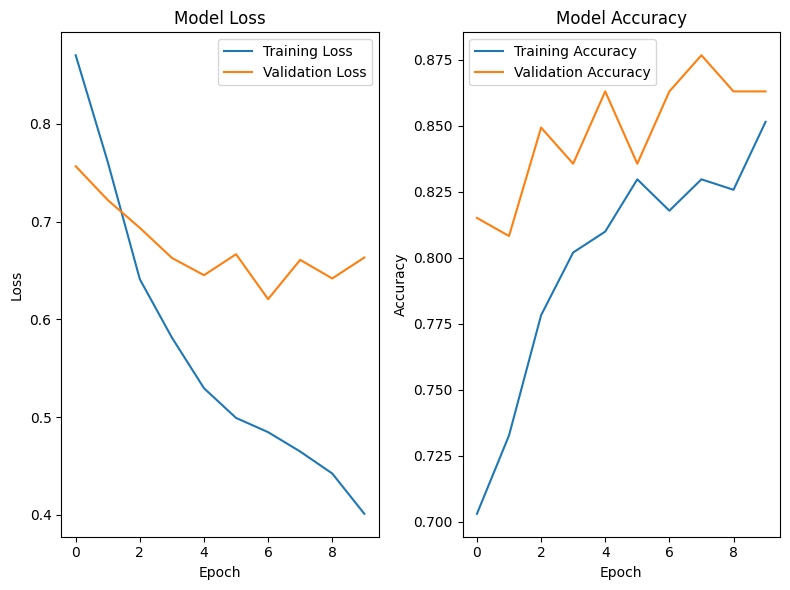

In [29]:
import matplotlib.pyplot as plt

# Plot the training and validation metrics
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

3/3 [==============================] - 0s 123ms/step


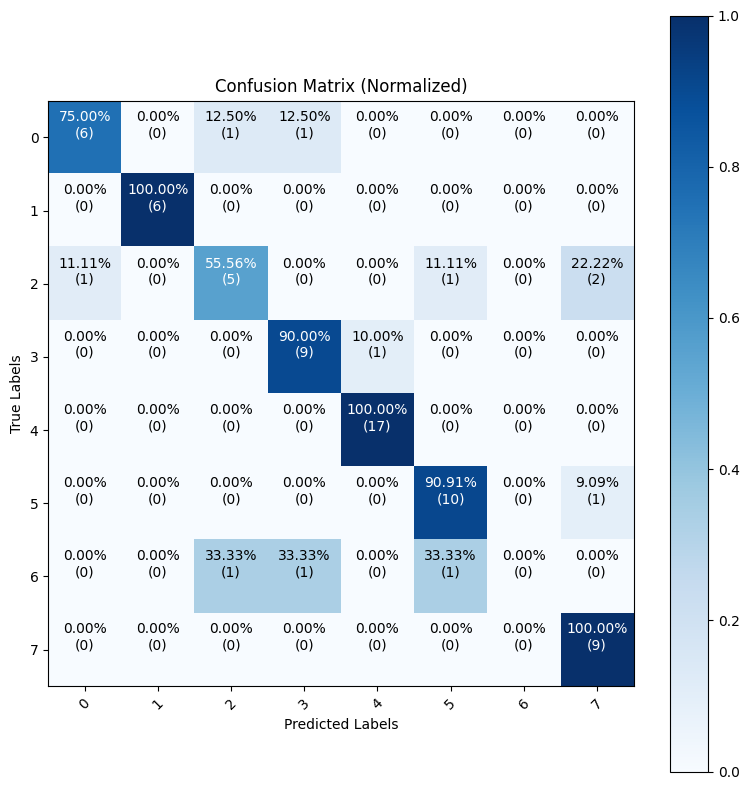

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

# Make predictions on the test set
test_dataset = create_dataset("/content/Ship-Vessel-Identification-2_SD_ImagePrompt_2-1/test")
test_images = []
test_labels = []

for images, labels in test_dataset:
    test_images.extend(images.numpy())
    test_labels.append(labels.numpy())
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Reshape the test images to include the channel dimension
test_images = test_images.reshape((-1, 224, 224, 3))
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Create the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Normalized)')
plt.colorbar()
tick_marks = np.arange(len(np.unique(test_labels)))
plt.xticks(tick_marks, np.unique(test_labels), rotation=45)
plt.yticks(tick_marks, np.unique(test_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add values on top of each cell
thresh = cm_norm.max() / 2.
for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
    plt.text(j, i, f"{cm_norm[i, j]*100:.2f}%\n({cm[i, j]})", horizontalalignment="center", color="white" if cm_norm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [31]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       1.00      1.00      1.00         6
           2       0.71      0.56      0.63         9
           3       0.82      0.90      0.86        10
           4       0.94      1.00      0.97        17
           5       0.83      0.91      0.87        11
           6       0.00      0.00      0.00         3
           7       0.75      1.00      0.86         9

    accuracy                           0.85        73
   macro avg       0.74      0.76      0.75        73
weighted avg       0.81      0.85      0.83        73



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
